In [18]:
# 0. INSTALL AND IMPORT LIBRARIES
# ========================
!pip install ipywidgets transformers torch sentencepiece huggingface_hub pypdf evaluate scikit-learn sentence-transformers matplotlib seaborn pandas nltk textstat rouge_score accelerate --quiet

import os
import warnings
import time
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import nltk
import textstat

import ipywidgets as widgets
from IPython.display import display, HTML

import torch
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import evaluate

warnings.filterwarnings("ignore")

print("✅ Libraries installed and imported successfully.")

✅ Libraries installed and imported successfully.


In [19]:
import warnings
warnings.filterwarnings("ignore")

# Optional: disable Hugging Face's specific "accelerate" logs
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("accelerate").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)


In [20]:
# 1. HUGGING FACE AUTHENTICATION
# ========================
try:
    HF_TOKEN = os.environ.get('HF_TOKEN')  # Or Colab secret
    login(token=HF_TOKEN)
    print("✅ Hugging Face Hub login successful.")
except Exception as e:
    print(f"🛑 Hugging Face login failed. Ensure HF_TOKEN is set.")
    print(e)

✅ Hugging Face Hub login successful.


In [21]:
# 2. DOWNLOAD NLTK DATA
# ========================
try:
    nltk.download('punkt', quiet=True)
except Exception as e:
    print(f"Error downloading NLTK data: {e}")

In [22]:
# 3. LOAD MODELS
# ========================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

MODELS = {}
rouge_metric = evaluate.load("rouge")

# TinyLlama
model_id_tiny = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
MODELS['tinyllama'] = {'tokenizer': AutoTokenizer.from_pretrained(model_id_tiny),
                       'model': AutoModelForCausalLM.from_pretrained(model_id_tiny, torch_dtype=torch.bfloat16, device_map="auto"),
                       'name': "TinyLlama-1.1B-Chat"}

# Phi
model_id_phi = "microsoft/phi-2"
MODELS['phi'] = {'tokenizer': AutoTokenizer.from_pretrained(model_id_phi, trust_remote_code=True),
                 'model': AutoModelForCausalLM.from_pretrained(model_id_phi, torch_dtype=torch.bfloat16, device_map="auto", trust_remote_code=True),
                 'name': "Phi-2"}

# BART
model_id_bart = "facebook/bart-large-cnn"
MODELS['bart'] = {'summarizer': pipeline("summarization", model=model_id_bart, device=0 if device=="cuda" else -1),
                  'name': 'BART-Large-CNN'}

# Gemma
model_id_gemma = "google/gemma-2b-it"
MODELS['gemma'] = {'tokenizer': AutoTokenizer.from_pretrained(model_id_gemma, token=HF_TOKEN),
                   'model': AutoModelForCausalLM.from_pretrained(model_id_gemma, torch_dtype=torch.bfloat16, device_map="auto", token=HF_TOKEN),
                   'name': "Gemma-2B-IT"}

# TextRank embeddings
MODELS['embedding'] = {'model': SentenceTransformer('all-MiniLM-L6-v2', device=device),
                       'name': 'TextRank (Embeddings)'}

print("🎉 All models loaded successfully!")

Using device: cpu


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

🎉 All models loaded successfully!


In [24]:
# 4. SUMMARIZATION FUNCTIONS
# ========================
def generate_with_chat_template_model(model_key, prompt, max_new_tokens=250):
    tokenizer = MODELS[model_key]['tokenizer']
    model = MODELS[model_key]['model']

    # Some tokenizers may not have apply_chat_template; fallback to simple prompt
    if hasattr(tokenizer, 'apply_chat_template'):
        chat = [{"role": "user", "content": prompt}]
        formatted_prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    else:
        formatted_prompt = prompt

    inputs = tokenizer.encode(formatted_prompt, add_special_tokens=True, return_tensors="pt").to(model.device)
    outputs = model.generate(input_ids=inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)

def generate_with_instruct_model(model_key, prompt, max_new_tokens=250):
    tokenizer = MODELS[model_key]['tokenizer']
    model = MODELS[model_key]['model']
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    if "Output:" in decoded_output:
        return decoded_output.split("Output:")[1].strip()
    return decoded_output

def summarize_abstractive(text, model_key, max_len=200, min_len=50):
    if model_key == 'tinyllama':
        prompt = f"Provide a concise, abstractive summary of the following text:\n\n{text[:2000]}"
        return generate_with_chat_template_model(model_key, prompt, max_new_tokens=max_len)
    elif model_key == 'phi':
        prompt = f"Instruct: Summarize the following text concisely.\n{text[:2000]}\nOutput:"
        return generate_with_instruct_model(model_key, prompt, max_new_tokens=max_len)
    elif model_key == 'bart':
        return MODELS['bart']['summarizer'](text[:4096], max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']
    return "Unsupported model."

def summarize_extractive(text, model_key, num_sentences=5):
    if model_key in ['tinyllama', 'phi']:
        return summarize_abstractive(text, model_key, max_len=num_sentences*50)
    elif model_key == 'embedding':
        try:
            sentences = nltk.sent_tokenize(text)
            if len(sentences) <= num_sentences: return "\n".join(sentences)
            embeddings = MODELS['embedding']['model'].encode(sentences, convert_to_tensor=True)
            sim_matrix = cosine_similarity(embeddings.cpu().numpy())
            graph = nx.from_numpy_array(sim_matrix)
            scores = nx.pagerank(graph)
            ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
            return "\n".join([s for _, s in ranked_sentences[:num_sentences]])
        except Exception as e:
            return f"TextRank failed: {e}"
    return "Unsupported model."

In [25]:
# 5. METRICS AND VISUALIZATION
# ========================
def calculate_metrics(summary, original_text, processing_time):
    embedding_model = MODELS['embedding']['model']
    embeddings = embedding_model.encode([original_text, summary])
    semantic_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    rouge_scores = rouge_metric.compute(predictions=[summary], references=[original_text])
    return {
        "ROUGE-1": round(rouge_scores['rouge1'], 3),
        "ROUGE-2": round(rouge_scores['rouge2'], 3),
        "Semantic Similarity": round(semantic_sim, 3),
        "Readability": round(textstat.flesch_reading_ease(summary), 2),
        "Length (words)": len(summary.split()),
        "Time (sec)": round(processing_time, 2),
        "Compression": f"{(1 - (len(summary.split()) / len(original_text.split()))) * 100:.1f}%" if len(original_text.split()) > 0 else "N/A"
    }


In [26]:
# 6. VISUALIZATION FUNCTIONS
# ========================
def create_bar_charts(metrics_df):
    if metrics_df.empty: return None
    df_sorted = metrics_df.sort_values(by=['Model']).reset_index(drop=True)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('📊 Model Performance Comparison', fontsize=18, fontweight='bold')
    colors = sns.color_palette("tab10", n_colors=len(df_sorted['Model'].unique()))

    sns.barplot(data=df_sorted, x='Model', y='ROUGE-1', ax=axes[0], palette=colors).tick_params(axis='x', rotation=45)
    axes[0].set_title('ROUGE-1 Score', fontsize=14, fontweight='bold')

    sns.barplot(data=df_sorted, x='Model', y='Semantic Similarity', ax=axes[1], palette=colors).tick_params(axis='x', rotation=45)
    axes[1].set_title('Semantic Similarity', fontsize=14, fontweight='bold')

    sns.barplot(data=df_sorted, x='Model', y='Time (sec)', ax=axes[2], palette=colors).tick_params(axis='x', rotation=45)
    axes[2].set_title('Processing Time (seconds)', fontsize=14, fontweight='bold')

    for ax in axes:
        ax.set_facecolor('#f9f9f9')
        ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

def create_radar_chart(metrics_df):
    if metrics_df.empty: return None
    metrics_to_plot = ['ROUGE-1', 'Semantic Similarity', 'Readability']
    df_radar = metrics_df.copy()
    df_radar['Readability'] = np.clip(df_radar['Readability'] / 100.0, 0, 1)
    df_avg = df_radar.groupby('Model')[metrics_to_plot].mean().reset_index()

    labels, num_vars = df_avg.columns[1:], len(df_avg.columns[1:])
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    colors = sns.color_palette("Set2", n_colors=len(df_avg))

    for i, row in df_avg.iterrows():
        values = row.drop('Model').tolist() + [row.drop('Model').tolist()[0]]
        ax.plot(angles, values, label=row['Model'], linewidth=2.5, color=colors[i])
        ax.fill(angles, values, alpha=0.3, color=colors[i])

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
    ax.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.set_title("✨ Multi-Metric Model Comparison", size=16, fontweight='bold', y=1.1)
    return fig

print("✅ Backend ready: Summarization, metrics, visualizations.")

✅ Backend ready: Summarization, metrics, visualizations.


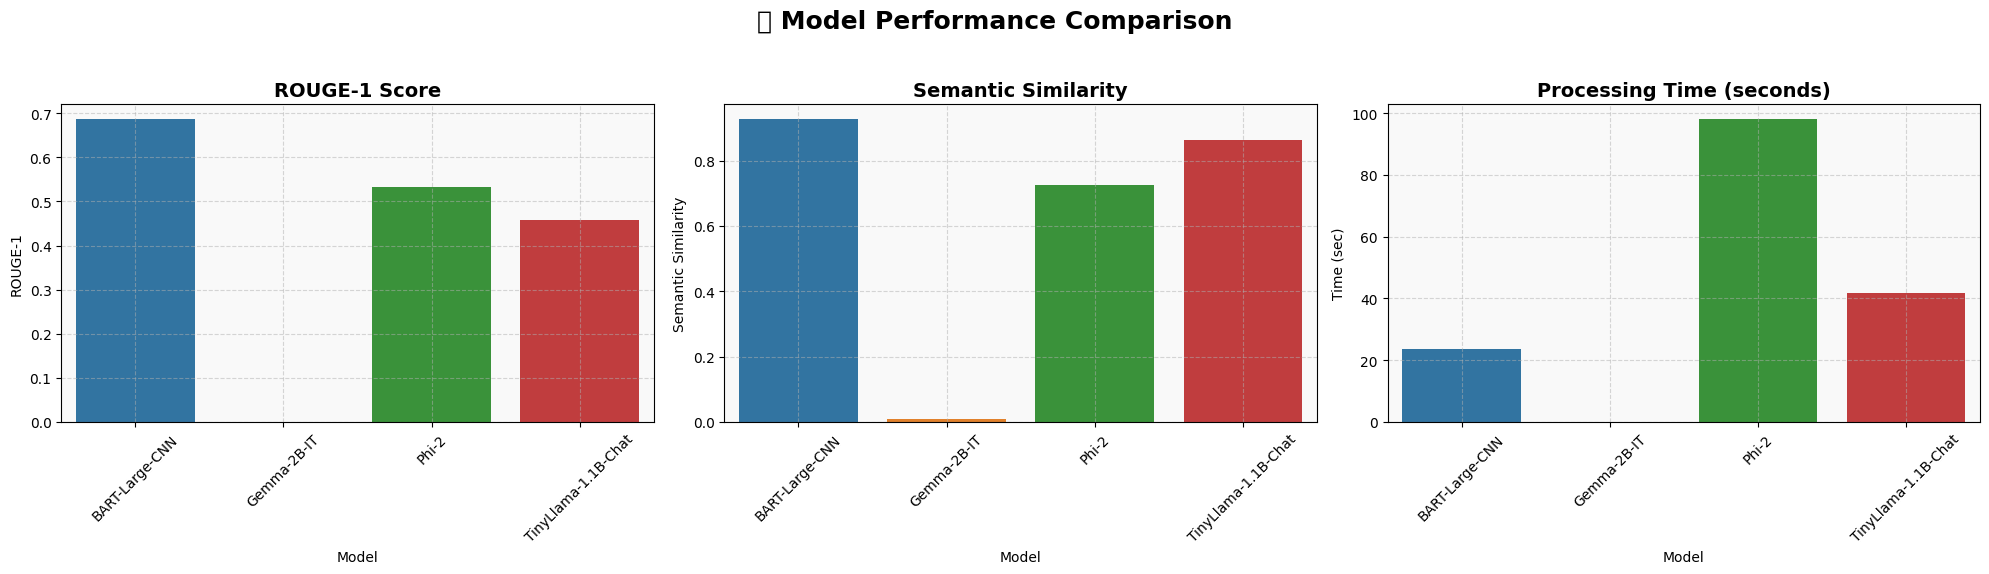

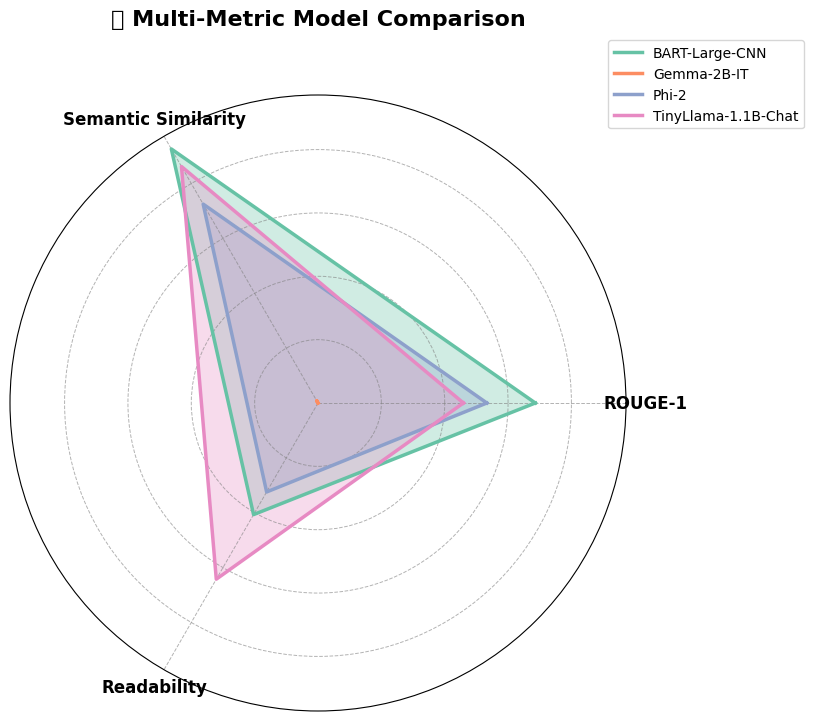

In [27]:
# 7. INTERACTIVE UI SECTIONS
# ========================
# Here you can reuse your previous UI code for:
# - Section A: Summarize with All Models
# - Section B: Summarize with Specific Models
# Just connect them with these new plot functions and updated MODELS dictionary
# 8. INTERACTIVE UI - SECTION A: ALL MODELS
# ========================

metrics_history_all = []

# Model choices
abstractive_models = [k for k in ['tinyllama','phi','bart','gemma']]
extractive_models = [k for k in ['tinyllama','phi','gemma','embedding']]

header_all = widgets.HTML("<h2>Section A: Summarize with All Models</h2><p>Paste text or load dataset. All compatible models will run automatically.</p>")
text_input_all = widgets.Textarea(placeholder="Paste your text here...", layout={'width':'99%','height':'180px'})
summary_type_all = widgets.RadioButtons(options=['Abstractive','Extractive'], value='Abstractive', description='Type:')
generate_button_all = widgets.Button(description='🚀 Generate All Summaries', button_style='primary')
clear_button_all = widgets.Button(description='🧹 Clear Outputs', button_style='warning')
load_dataset_button = widgets.FileUpload(accept=".txt,.csv", multiple=False, description="📂 Load External Text")

summary_output_all = widgets.Output(layout={'height':'400px','border':'1px solid #ccc','padding':'10px','overflow':'scroll'})
metrics_table_output_all = widgets.Output()
bar_plot_output_all = widgets.Output()
radar_plot_output_all = widgets.Output()
output_accordion_all = widgets.Accordion(children=[metrics_table_output_all, bar_plot_output_all, radar_plot_output_all])
output_accordion_all.set_title(0,'📊 Metrics Table')
output_accordion_all.set_title(1,'📈 Bar Charts')
output_accordion_all.set_title(2,'✨ Radar Plot')

def get_text_from_file(uploaded_file):
    try:
        for name, file_info in uploaded_file.items():
            if name.endswith(".txt"):
                return file_info['content'].decode("utf-8")
            elif name.endswith(".csv"):
                df = pd.read_csv(io.BytesIO(file_info['content']))
                return " ".join(df.iloc[:,0].astype(str).tolist())
    except:
        return ""

def on_generate_all(b):
    generate_button_all.disabled = True
    generate_button_all.description = "Processing..."
    text = text_input_all.value.strip()
    if not text:
        with summary_output_all: print("⚠️ Please paste text or load dataset.")
        generate_button_all.disabled = False
        generate_button_all.description = "🚀 Generate All Summaries"
        return
    s_type = summary_type_all.value
    model_keys = abstractive_models if s_type=='Abstractive' else extractive_models

    with summary_output_all: summary_output_all.clear_output()
    with summary_output_all: display(HTML(f"<hr><h3>Processing Text ({s_type})</h3>"))

    for mk in model_keys:
        model_name = MODELS[mk]['name']
        with summary_output_all: print(f"⏳ Summarizing with {model_name}...")
        start = time.time()
        summary = summarize_abstractive(text, mk) if s_type=='Abstractive' else summarize_extractive(text, mk)
        elapsed = time.time() - start
        with summary_output_all: display(HTML(f"<h4>{model_name}</h4><p>{summary}</p>"))
        metrics = calculate_metrics(summary, text, elapsed)
        metrics.update({'Model': model_name,'File':'Pasted Text','Type':s_type})
        metrics_history_all.append(metrics)

    df = pd.DataFrame(metrics_history_all)
    with metrics_table_output_all: metrics_table_output_all.clear_output(wait=True); display(df)
    with bar_plot_output_all: bar_plot_output_all.clear_output(wait=True); display(create_bar_charts(df))
    with radar_plot_output_all: radar_plot_output_all.clear_output(wait=True); display(create_radar_chart(df))
    generate_button_all.disabled = False
    generate_button_all.description = "🚀 Generate All Summaries"

def on_clear_all(b):
    global metrics_history_all
    metrics_history_all=[]
    summary_output_all.clear_output()
    metrics_table_output_all.clear_output()
    bar_plot_output_all.clear_output()
    radar_plot_output_all.clear_output()
    text_input_all.value=""

def on_file_upload(change):
    text_input_all.value = get_text_from_file(change['new'])

generate_button_all.on_click(on_generate_all)
clear_button_all.on_click(on_clear_all)
load_dataset_button.observe(on_file_upload, names='value')

input_box_all = widgets.VBox([text_input_all, summary_type_all, widgets.HBox([generate_button_all, clear_button_all]), load_dataset_button], layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px'))
output_box_all = widgets.VBox([summary_output_all, output_accordion_all], layout=widgets.Layout(width='65%', padding='10px'))
app_all = widgets.VBox([header_all, widgets.HBox([input_box_all, output_box_all])])
display(app_all)


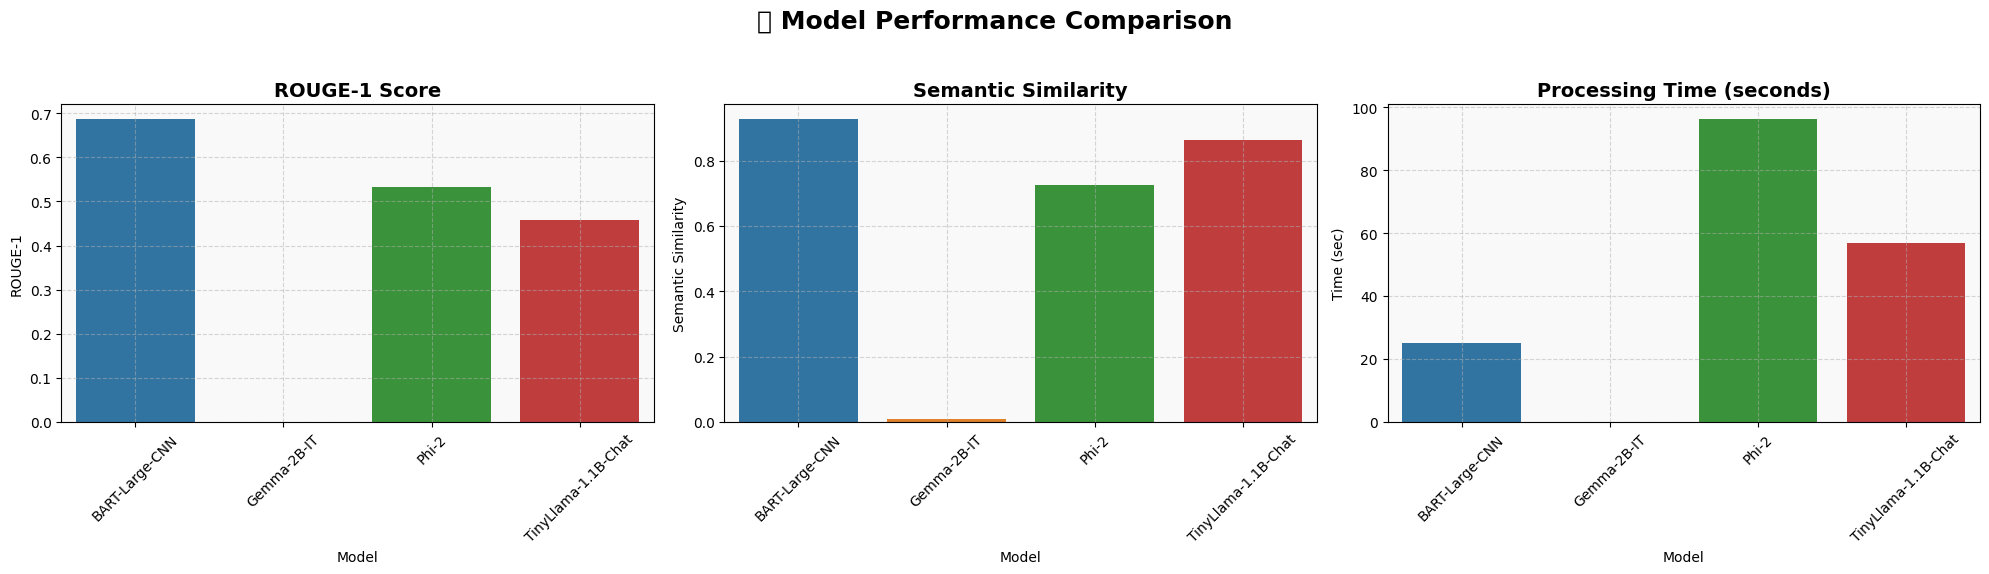

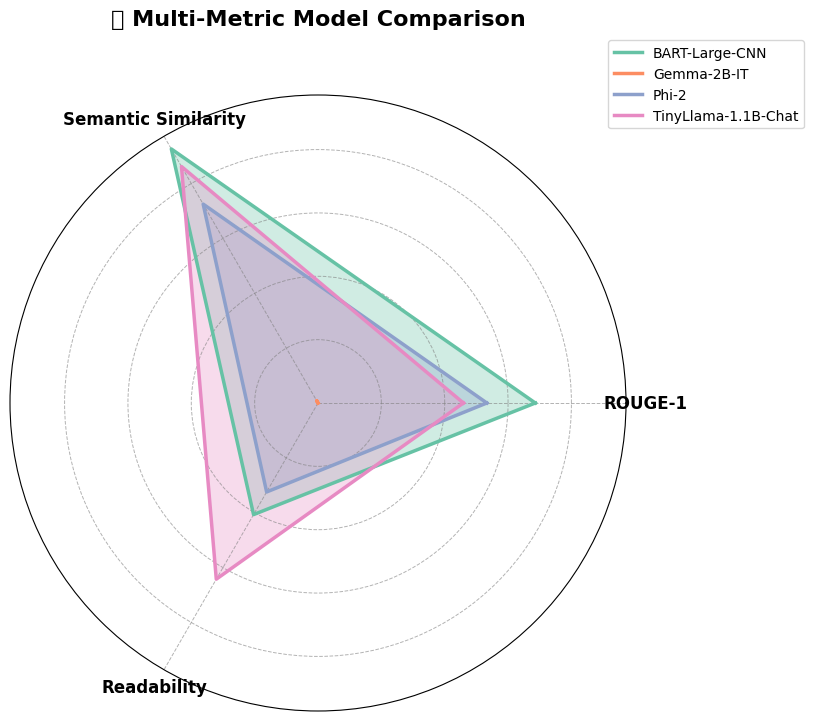

In [28]:
# 9. INTERACTIVE UI - SECTION B: SPECIFIC MODELS
# ========================

metrics_history_specific = []
checkboxes = {}

header_specific = widgets.HTML("<h2>Section B: Summarize with Specific Models</h2><p>Paste text, choose summary type, select models.</p>")
text_input_specific = widgets.Textarea(placeholder="Paste text here...", layout={'width':'99%','height':'180px'})
summary_type_specific = widgets.RadioButtons(options=['Abstractive','Extractive'], value='Abstractive')
model_checkboxes_out = widgets.Output()
generate_button_specific = widgets.Button(description='🚀 Generate Summaries', button_style='primary')
clear_button_specific = widgets.Button(description='🧹 Clear Outputs', button_style='warning')

summary_output_specific = widgets.Output(layout={'height':'400px','border':'1px solid #ccc','padding':'10px','overflow':'scroll'})
metrics_table_output_specific = widgets.Output()
bar_plot_output_specific = widgets.Output()
radar_plot_output_specific = widgets.Output()
output_accordion_specific = widgets.Accordion(children=[metrics_table_output_specific, bar_plot_output_specific, radar_plot_output_specific])
output_accordion_specific.set_title(0,'📊 Metrics Table')
output_accordion_specific.set_title(1,'📈 Bar Charts')
output_accordion_specific.set_title(2,'✨ Radar Plot')

def update_checkboxes(s_type):
    global checkboxes
    checkboxes={}
    choices = abstractive_models if s_type=='Abstractive' else extractive_models
    with model_checkboxes_out:
        model_checkboxes_out.clear_output(wait=True)
        for mk in choices:
            checkboxes[mk] = widgets.Checkbox(value=True, description=MODELS[mk]['name'])
        display(widgets.VBox(list(checkboxes.values())))

def on_generate_specific(b):
    generate_button_specific.disabled=True
    generate_button_specific.description="Processing..."
    text = text_input_specific.value.strip()
    s_type = summary_type_specific.value
    selected_keys = [k for k, cb in checkboxes.items() if cb.value]
    if not text or not selected_keys:
        with summary_output_specific: print("⚠️ Please paste text and select at least one model.")
        generate_button_specific.disabled=False
        generate_button_specific.description="🚀 Generate Summaries"
        return
    with summary_output_specific: summary_output_specific.clear_output()
    with summary_output_specific: display(HTML(f"<hr><h3>Processing Text ({s_type})</h3>"))
    for mk in selected_keys:
        model_name = MODELS[mk]['name']
        with summary_output_specific: print(f"⏳ Summarizing with {model_name}...")
        start = time.time()
        summary = summarize_abstractive(text, mk) if s_type=='Abstractive' else summarize_extractive(text, mk)
        elapsed = time.time()-start
        with summary_output_specific: display(HTML(f"<h4>{model_name}</h4><p>{summary}</p>"))
        metrics = calculate_metrics(summary, text, elapsed)
        metrics.update({'Model':model_name,'File':'Pasted Text','Type':s_type})
        metrics_history_specific.append(metrics)
    df = pd.DataFrame(metrics_history_specific)
    with metrics_table_output_specific: metrics_table_output_specific.clear_output(wait=True); display(df)
    with bar_plot_output_specific: bar_plot_output_specific.clear_output(wait=True); display(create_bar_charts(df))
    with radar_plot_output_specific: radar_plot_output_specific.clear_output(wait=True); display(create_radar_chart(df))
    generate_button_specific.disabled=False
    generate_button_specific.description="🚀 Generate Summaries"

def on_clear_specific(b):
    global metrics_history_specific
    metrics_history_specific=[]
    summary_output_specific.clear_output()
    metrics_table_output_specific.clear_output()
    bar_plot_output_specific.clear_output()
    radar_plot_output_specific.clear_output()
    text_input_specific.value=""

summary_type_specific.observe(lambda change: update_checkboxes(change.new), names='value')
generate_button_specific.on_click(on_generate_specific)
clear_button_specific.on_click(on_clear_specific)

input_box_specific = widgets.VBox([text_input_specific, summary_type_specific, widgets.Label("Select Models:"), model_checkboxes_out, widgets.HBox([generate_button_specific, clear_button_specific])], layout=widgets.Layout(width='35%', padding='10px', border='1px solid lightgrey', border_radius='5px'))
output_box_specific = widgets.VBox([summary_output_specific, output_accordion_specific], layout=widgets.Layout(width='65%', padding='10px'))
app_specific = widgets.VBox([header_specific, widgets.HBox([input_box_specific, output_box_specific])])
update_checkboxes('Abstractive')
display(app_specific)

In [29]:
# ========================
# 10. SAMPLE TEXTS
# ========================

sample_texts = {
    "News": """The global stock markets experienced a major downturn today as technology shares plunged amid fears of a global economic slowdown. Investors are closely monitoring central bank policies for signals about interest rate changes.""",
    "Science": """A team of astronomers has discovered a new exoplanet in the habitable zone of a nearby star. The planet, roughly the size of Earth, could have conditions suitable for liquid water and potentially life.""",
    "Health": """Researchers have found that a diet rich in fruits and vegetables can reduce the risk of chronic diseases. A balanced diet combined with regular exercise is key to long-term wellness.""",
    "Technology": """The latest smartphone release features a foldable display, enhanced AI-powered camera, and faster 5G connectivity. Experts predict it will set new trends in mobile technology.""",
    "Sports": """In an exciting football match, the underdog team managed a surprising victory against the reigning champions. Fans celebrated wildly as the final whistle blew.""",
    "Finance": """Cryptocurrency markets showed volatility today with Bitcoin prices dropping 5% after regulatory concerns surfaced. Traders are advised to exercise caution and diversify their portfolios.""",
    "Education": """Universities are increasingly offering online courses to adapt to digital learning trends. Students now have the flexibility to access high-quality education from anywhere.""",
    "Environment": """Climate change continues to impact global weather patterns. Scientists warn that urgent measures are needed to reduce greenhouse gas emissions and protect vulnerable ecosystems.""",
    "Entertainment": """The latest blockbuster movie broke box office records on opening weekend. Critics praised the performances and special effects, predicting a long run in theaters.""",
    "History": """Archaeologists have uncovered ancient ruins dating back 3,000 years. The site reveals insights into the daily lives, trade, and culture of civilizations that existed in that region."""
}


In [30]:
# 11. TESTING SAMPLE TEXTS
# ========================

sample_dropdown = widgets.Dropdown(
    options=list(sample_texts.keys()),
    description="Select Text:",
    layout={'width':'300px'}
)

def load_sample(change):
    selected = change['new']
    text_input_all.value = sample_texts[selected]
    text_input_specific.value = sample_texts[selected]

sample_dropdown.observe(load_sample, names='value')
display(sample_dropdown)


Dropdown(description='Select Text:', layout=Layout(width='300px'), options=('News', 'Science', 'Health', 'Tech…